In [1]:
from qbs import qbs

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.datasets as datasets
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from imblearn.under_sampling import (AllKNN, ClusterCentroids, CondensedNearestNeighbour,
                                     EditedNearestNeighbours, InstanceHardnessThreshold, NearMiss,
                                     NeighbourhoodCleaningRule, OneSidedSelection, RandomUnderSampler,
                                     RepeatedEditedNearestNeighbours, TomekLinks)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

import warnings
warnings.filterwarnings('ignore')

In [2]:
class QBS:
    def __init__(self, version=1):
        self.version = version
    def fit_resample(self, X, y):
        X_resampled, y_resampled = qbs(X, y, self.version)
        return X_resampled, y_resampled

In [3]:
# Load example dataset
data = datasets.load_wine()
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=RANDOM_STATE)

X_train, y_train = shuffle(X_train, y_train, random_state=RANDOM_STATE)

# Find the unique class labels and their counts
unique_classes, class_counts = np.unique(y_train, return_counts=True)

# Identify the minority class
minority_class = unique_classes[np.argmin(class_counts)]

# Set the percentage to reduce the minority class by
reduction_percentage = 0.5

# Get the indices of the minority class samples
minority_indices = np.where(y_train == minority_class)[0]

# Calculate the number of samples to remove
num_samples_to_remove = int(len(minority_indices) * reduction_percentage)

# Randomly select samples to remove
samples_to_remove = np.random.choice(minority_indices, size=num_samples_to_remove, replace=False)

# Remove the selected samples from the training data
X_train = np.delete(X_train, samples_to_remove, axis=0)
y_train = np.delete(y_train, samples_to_remove, axis=0)

In [4]:
undersampling_methods = {
    'QBS': QBS(version=2),
    'AllKNN': AllKNN(),
    'ClusterCentroids': ClusterCentroids(random_state=RANDOM_STATE),
    'CondensedNearestNeighbour': CondensedNearestNeighbour(random_state=RANDOM_STATE),
    'EditedNearestNeighbours': EditedNearestNeighbours(),
    'InstanceHardnessThreshold': InstanceHardnessThreshold(random_state=RANDOM_STATE),
    'NearMiss': NearMiss(version=1),
    'NeighborhoodCleaningRule': NeighbourhoodCleaningRule(),
    'OneSidedSelection': OneSidedSelection(random_state=RANDOM_STATE),
    'RandomUnderSampler': RandomUnderSampler(random_state=RANDOM_STATE),
    'RepeatedEditedNN': RepeatedEditedNearestNeighbours(),
    'TomekLinks': TomekLinks(),
}

results = []

for name, method in undersampling_methods.items():
    try:
        start = time.process_time()
        X_resampled, y_resampled = method.fit_resample(X_train, y_train)
        end = time.process_time()
        # print(f'{name}: {end - start}')

        # Create pipeline
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', DecisionTreeClassifier(random_state=RANDOM_STATE))
        ])

        # Train and evaluate the classifier
        pipeline.fit(X_resampled, y_resampled)
        y_pred = pipeline.predict(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')

        # Calculate confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        results.append({
            'method': name,
            'samples': len(X_resampled),
            'class_distribution': dict(pd.Series(y_resampled).value_counts()),
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'time (s)': end - start,
            'confusion_matrix': cm
        })
    except Exception as e:
        print(f'{name}: {e}')

# Display results
results_df = pd.DataFrame(results).sort_values(['f1_score'], ascending=False)
results_df[['method', 'samples', 'time (s)', 'class_distribution',
            'accuracy', 'precision', 'recall', 'f1_score']].style.hide_index()

method,samples,time (s),class_distribution,accuracy,precision,recall,f1_score
QBS,41,0.024028,"{1: 17, 0: 13, 2: 11}",0.932584,0.941126,0.934938,0.937790
TomekLinks,65,0.000348,"{1: 31, 2: 21, 0: 13}",0.910112,0.922454,0.915033,0.918255
InstanceHardnessThreshold,39,0.971849,"{0: 13, 1: 13, 2: 13}",0.910112,0.908586,0.900178,0.903062
NearMiss,39,0.000617,"{0: 13, 1: 13, 2: 13}",0.853933,0.861871,0.860665,0.860147
NeighborhoodCleaningRule,55,0.001427,"{1: 26, 2: 16, 0: 13}",0.853933,0.875238,0.867201,0.853110
RandomUnderSampler,39,0.000283,"{0: 13, 1: 13, 2: 13}",0.842697,0.862043,0.825312,0.833182
ClusterCentroids,39,0.207551,"{0: 13, 1: 13, 2: 13}",0.808989,0.815108,0.820559,0.817629
CondensedNearestNeighbour,21,0.017793,"{0: 13, 1: 4, 2: 4}",0.775281,0.769542,0.781937,0.766123
OneSidedSelection,25,0.001582,"{0: 13, 2: 9, 1: 3}",0.730337,0.825000,0.743316,0.736667
EditedNearestNeighbours,38,0.002165,"{1: 18, 0: 13, 2: 7}",0.719101,0.690453,0.695781,0.690821


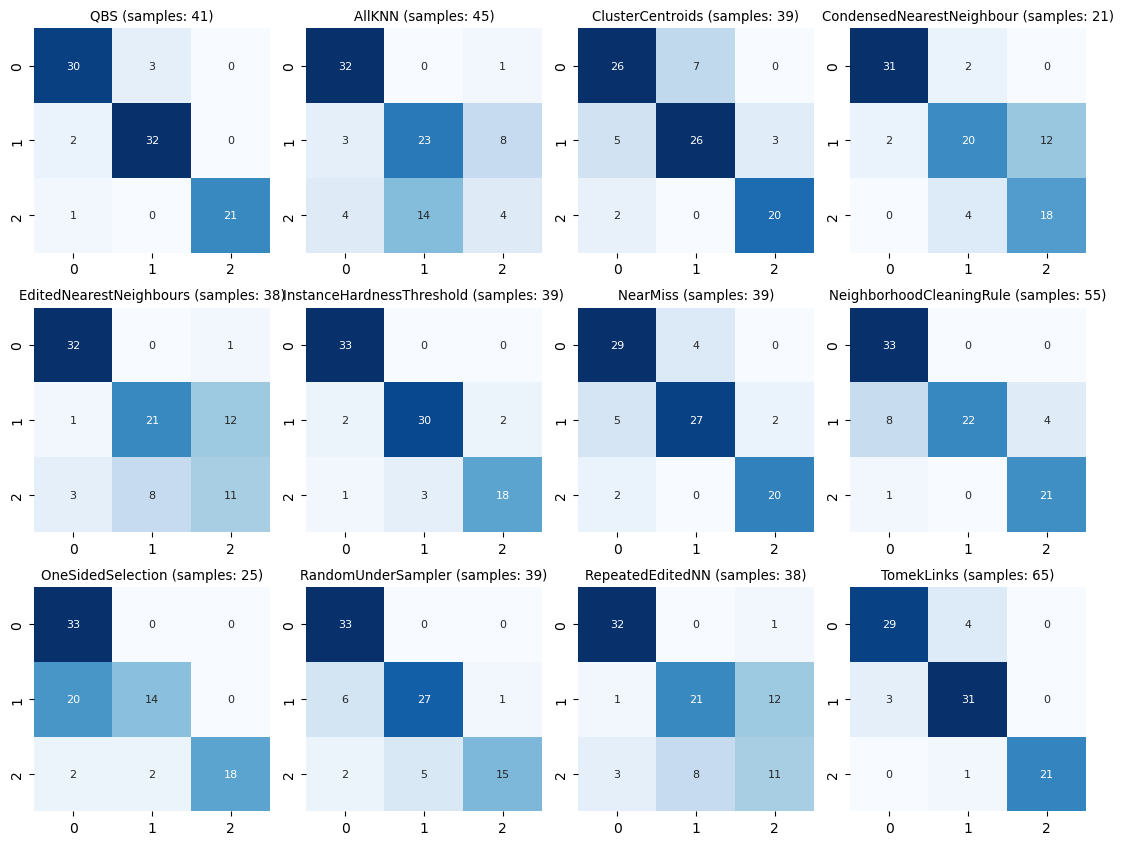

In [5]:
# Plot confusion matrices
fig, axes = plt.subplots(3, 4, figsize=(11, 8.5))
plt.rc('font', size=8)
axes = axes.flatten()

for i, result in enumerate(results):
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False)
    axes[i].set_title(f"{result['method']} (samples: {result['samples']})")

# Remove extra subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()